In [1]:
import pandas as pd
import numpy as np
import requests 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier


In [2]:
years = [2017,2018,2019]
activity_url = 'https://amphis.rails-apps.de/sites/{}/activity.csv?year={}'
df4 = pd.concat([pd.read_csv(activity_url.format(4, year)) for year in years])
df3 = pd.concat([pd.read_csv(activity_url.format(3, year)) for year in years])
df_training = pd.concat([df3,df4])

In [3]:
df_training=df_training[['Datum','Luftfeuchtigkeit [%]','Anzahl','Site','Temperature min','Temperature max','Windspeed avg','Windspeed max']]
df_training.columns = df_training.columns.str.replace('[^a-zA-Z]', '')
df_training['purpose']='training'
df_training.dropna(inplace=True)


In [4]:
sites = [3,4]
forecast_url = 'https://amphis.rails-apps.de/sites/{}/forecasts.csv'
dfs = []
for site in sites:
    try:
        dfs.append(pd.read_csv(forecast_url.format(site)))
    except:
        print("No forecast data for site %d" % site)
df_forecast = pd.concat(dfs)

In [5]:
df_forecast.rename(columns={'Standort-ID':'Site', \
                           'Humidity avg':'Luftfeuchtigkeit', \
                           'Min. Temp. (°C)': 'Temperaturemin', \
                           'Max. Temp. (°C)': 'Temperaturemax', \
                           'Wind speed avg kmh': 'Windspeedavg', \
                           'Wind speed max kmh': 'Windspeedmax'}, inplace=True)

In [6]:
df_forecast=df_forecast[['Datum','Site','Luftfeuchtigkeit','Temperaturemin','Temperaturemax','Windspeedavg', 'Windspeedmax']]
df_forecast['purpose']='forecast'
df_forecast.dropna(inplace=True)

df_predictions = df_forecast[['Datum','Site']]

In [7]:
df = pd.concat([df_training, df_forecast])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [8]:
df['date'] = df['Datum'].astype('datetime64') 
df = df.drop(columns=['Datum'])
df['doy']=df.apply(lambda x:x.date.timetuple().tm_yday, axis = 1)
df['year']=df.apply(lambda x:x.date.year, axis = 1)

In [9]:
def passed(df, Site, year, doy):
    df_filtered = df[(df['Site'] == Site) \
       & (df['year']==year) \
       & (df['doy'] < doy) ]
    return df_filtered.Anzahl.sum()
df['passed'] = df.apply(lambda x: passed(df, x.Site, x.year, x.doy), axis = 1)

In [10]:
def add_history_data(df):
    df_day1 = df.copy().drop(columns=['purpose']).rename(index=str, columns={"Luftfeuchtigkeit": "Luftfeuchtigkeit_day1", "Anzahl": "Anzahl_day1", \
                                                   "Temperaturemin": "Temperaturemin_day1",
                                                   "Temperaturemax": "Temperaturemax_day1", \
                                                   "Windspeedavg": "Windspeedavg_day1",
                                                   "Windspeedmax": "Windspeedmax_day1", "passed": "passed_day1"})
    df_day1['date'] = pd.to_datetime(df_day1['date']).apply(pd.DateOffset(-1))
    df_day1.drop(columns=['year', 'doy'], inplace=True)
    df_hist1 = pd.merge(df, df_day1, how='left', on=['date', 'Site'])

    df_day2 = df.copy().drop(columns=['purpose']).rename(index=str, columns={"Luftfeuchtigkeit": "Luftfeuchtigkeit_day2", "Anzahl": "Anzahl_day2", \
                                                   "Temperaturemin": "Temperaturemin_day2",
                                                   "Temperaturemax": "Temperaturemax_day2", \
                                                   "Windspeedavg": "Windspeedavg_day2",
                                                   "Windspeedmax": "Windspeedmax_day2", "passed": "passed_day2"})
    df_day2['date'] = pd.to_datetime(df_day2['date']).apply(pd.DateOffset(-2))
    df_day2.drop(columns=['year', 'doy'], inplace=True)
    df_hist2 = pd.merge(df_hist1, df_day2, how='left', on=['date', 'Site'])

    df_day3 = df.copy().drop(columns=['purpose']).rename(index=str, columns={"Luftfeuchtigkeit": "Luftfeuchtigkeit_day3", "Anzahl": "Anzahl_day3", \
                                                   "Temperaturemin": "Temperaturemin_day3",
                                                   "Temperaturemax": "Temperaturemax_day3", \
                                                   "Windspeedavg": "Windspeedavg_day3",
                                                   "Windspeedmax": "Windspeedmax_day3", "passed": "passed_day3"})
    df_day3['date'] = pd.to_datetime(df_day3['date']).apply(pd.DateOffset(-3))
    df_day3.drop(columns=['year', 'doy'], inplace=True)
    df_hist3 = pd.merge(df_hist2, df_day3, how='left', on=['date', 'Site'])
    return df_hist3

df_hist=add_history_data(df)


In [11]:
def bucket(Anzahl, purpose):
    if(purpose=='forecast'):
        return ""
    if(Anzahl==0):
        return "0"
    if(Anzahl<50):
        return "1-50"
    if(Anzahl<150):
        return "50-150"
    if(Anzahl<300):
        return "150-300"
    return ">300"

df_hist['bucket'] = df_hist.apply(lambda x: bucket(x.Anzahl, x.purpose), axis=1)

In [12]:
def float2int(df):
    float_col = df.select_dtypes(include = ['float64']) # This will select float columns only
    for col in float_col.columns.values:
        df[col] = df[col].astype('int64')
    return df

df_hist = df_hist.fillna(0)
df_hist = float2int(df_hist)

In [13]:
df_training = df_hist.query("purpose=='training'")
df_forecast = df_hist.query("purpose=='forecast'")
df_x = df_training.drop(columns=['Anzahl','date','bucket','purpose'])
df_y = df_training[['bucket']]
df_forecast.drop(columns=['purpose','date','bucket','Anzahl'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.30)

In [15]:
clf = RandomForestClassifier(n_estimators=30, max_depth=15, \
                             class_weight={"0":1, "1-50":1, "50-150": 5, "150-300":20, ">300":40})
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(accuracy_score(y_pred,y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5794392523364486
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        42
        1-50       0.53      0.78      0.63        36
     150-300       0.00      0.00      0.00        12
      50-150       0.00      0.00      0.00        12
        >300       0.00      0.00      0.00         5

   micro avg       0.58      0.58      0.58       107
   macro avg       0.25      0.32      0.28       107
weighted avg       0.47      0.58      0.52       107

[[34  8  0  0  0]
 [ 7 28  0  1  0]
 [ 3  6  0  0  3]
 [ 2  9  0  0  1]
 [ 0  2  1  2  0]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. %s (%f)" % (f + 1, df_x.columns[indices[f]], importances[indices[f]]))    

Feature ranking:
1. Anzahl_day1 (0.100873)
2. Anzahl_day2 (0.073534)
3. passed_day2 (0.072064)
4. doy (0.065359)
5. passed_day3 (0.057596)
6. Anzahl_day3 (0.055767)
7. passed (0.043745)
8. Temperaturemax_day1 (0.042387)
9. Windspeedmax_day1 (0.038344)
10. passed_day1 (0.035416)
11. Luftfeuchtigkeit_day1 (0.033663)
12. Site (0.030041)
13. Windspeedmax_day2 (0.027984)
14. Temperaturemin_day2 (0.026249)
15. Luftfeuchtigkeit (0.023550)
16. Temperaturemin_day1 (0.023469)
17. Windspeedavg_day1 (0.023447)
18. Windspeedmax_day3 (0.022533)
19. Luftfeuchtigkeit_day3 (0.022520)
20. Temperaturemax (0.021939)
21. Temperaturemax_day3 (0.021869)
22. Temperaturemin (0.021594)
23. year (0.019618)
24. Windspeedmax (0.016888)
25. Temperaturemin_day3 (0.015225)
26. Windspeedavg (0.014967)
27. Luftfeuchtigkeit_day2 (0.013669)
28. Windspeedavg_day2 (0.012875)
29. Temperaturemax_day2 (0.011891)
30. Windspeedavg_day3 (0.010925)


In [19]:
from sklearn.svm import LinearSVC
clf = LinearSVC(class_weight={"0":1, "1-50":1, "50-150": 5, "150-300":20, ">300":40})
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(accuracy_score(y_pred,y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.29906542056074764
              precision    recall  f1-score   support

           0       0.33      0.02      0.04        42
        1-50       0.38      0.42      0.40        36
     150-300       0.18      0.92      0.31        12
      50-150       0.00      0.00      0.00        12
        >300       1.00      1.00      1.00         5

   micro avg       0.30      0.30      0.30       107
   macro avg       0.38      0.47      0.35       107
weighted avg       0.33      0.30      0.23       107

[[ 1 20 21  0  0]
 [ 2 15 19  0  0]
 [ 0  1 11  0  0]
 [ 0  3  9  0  0]
 [ 0  0  0  0  5]]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight={"0":1, "1-50":1, "50-150": 5, "150-300":20, ">300":40})
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(accuracy_score(y_pred,y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.5607476635514018
              precision    recall  f1-score   support

           0       0.70      0.71      0.71        42
        1-50       0.58      0.53      0.55        36
     150-300       0.29      0.17      0.21        12
      50-150       0.24      0.33      0.28        12
        >300       0.71      1.00      0.83         5

   micro avg       0.56      0.56      0.56       107
   macro avg       0.50      0.55      0.52       107
weighted avg       0.56      0.56      0.56       107

[[30  8  1  3  0]
 [10 19  3  4  0]
 [ 1  1  2  6  2]
 [ 2  5  1  4  0]
 [ 0  0  0  0  5]]


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


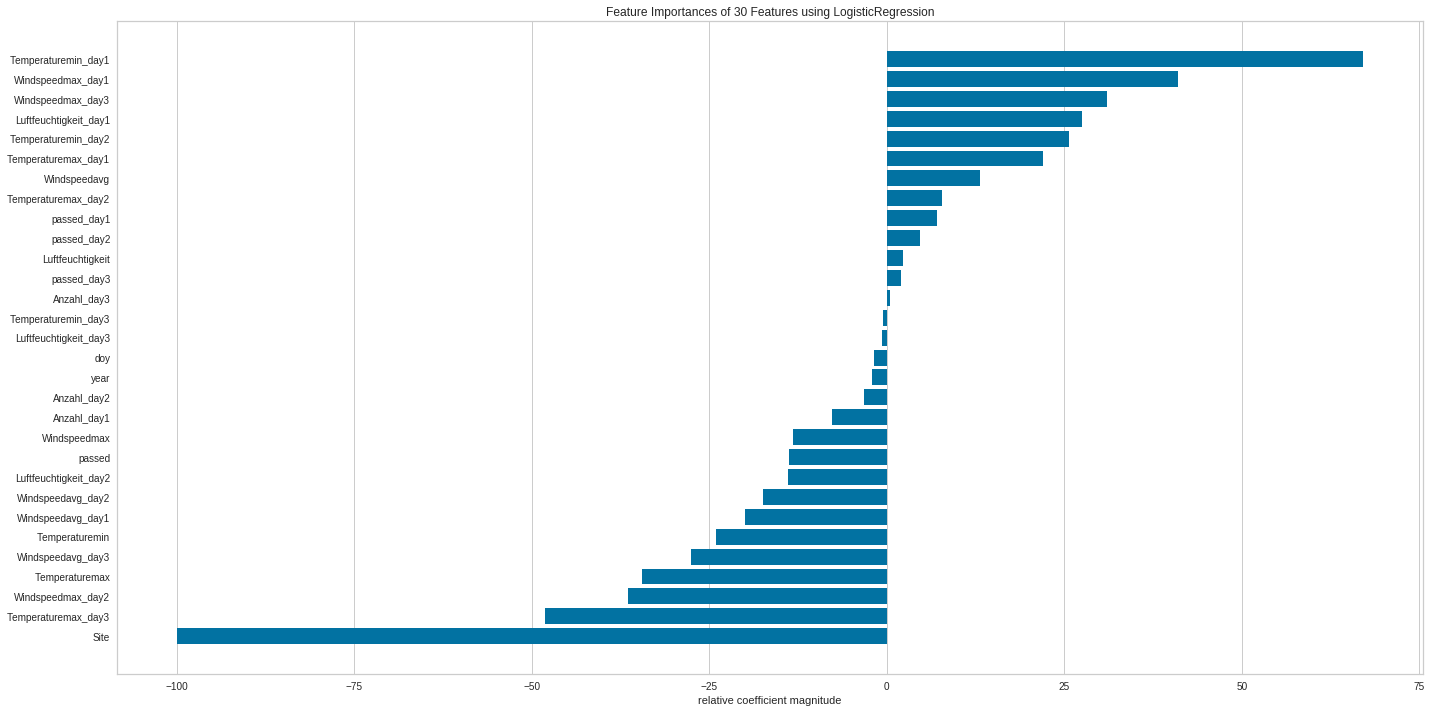

In [25]:
from yellowbrick.features.importances import FeatureImportances
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()
clf = LogisticRegression(C=.1, class_weight={"0":1, "1-50":1, "50-150": 5, "150-300":20, ">300":40})
viz = FeatureImportances(clf, ax=ax)
viz.fit(x_train, y_train)
viz.poof()

In [27]:
y_pred_live = clf.predict(df_forecast)

In [29]:
df_predictions['Anzahl']=y_pred_live

In [30]:
df_predictions.to_dict(orient='records')

[{'Datum': '2019-08-23', 'Site': 3, 'Anzahl': '0'},
 {'Datum': '2019-08-24', 'Site': 3, 'Anzahl': '0'},
 {'Datum': '2019-08-24', 'Site': 4, 'Anzahl': '0'},
 {'Datum': '2019-08-25', 'Site': 4, 'Anzahl': '0'},
 {'Datum': '2019-08-26', 'Site': 4, 'Anzahl': '0'},
 {'Datum': '2019-08-27', 'Site': 4, 'Anzahl': '0'},
 {'Datum': '2019-08-28', 'Site': 4, 'Anzahl': '0'}]